In this notebook, we will use Skyrim to get ECMWF's [Integrated Forecast System)](https://confluence.ecmwf.int/display/FUG/Forecast+User+Guide) (IFS) predictions.  Specifically, we will be utilizing the `HRES` configuration of the system. 

For more information: [see this](https://www.ecmwf.int/en/forecasts/datasets/open-data), [and this.](https://github.com/ecmwf/ecmwf-opendata)

🛑 This notebook does not require any GPU.

🪁 Again, we will focus on the wind-speed predictions for the Akyaka region in Turkey.

Our approach:
1. Initialize the IFSModel with the variables of interest, i.e., `u10m`, `v10m`, `t2m`.
2. Get global predictions for these variables given a forecast start date, start time and lead time, i.e. `"20240611"`, `"0000"`, `24*7`
3. Extract and calculate the wind speed predictions (from `u10m` and `v10m`) at Akyaka from the acquired forecast.
4. Introduce `IFSModel.snipe()` method, which retrieves the forecast for a specific target datetime, considering multiple possible start times. With this approach you can see how newly assimilated data changes the forecast. (can also be utilized as a proxy for uncertainty)

☢️️ NOTE:
Acquired forecasts should be taken with a grain of salt—our observations at Akyaka suggest that global weather models fail to capture the local wind characteristics of the kitesurfing beach. :)


In [1]:
from skyrim.libs.nwp import IFSModel

In [2]:
import sys
from loguru import logger
logger.remove()
logger.add(sys.stderr, level="INFO")

1

In [3]:
# to see the available channels use the following command
IFSModel.list_available_channels()[0:10]

['u10m', 'v10m', 'u100m', 'v100m', 't2m', 'sp', 'msl', 'tcwv', 'tp', 'u50']

In [4]:
# specify the channels you are interested in
channels = [
    "u10m", # u-component (eastward, zonal) of wind at 10 meters
    "v10m", # v-component (northward, meridional) of wind at 10 meters
    "t2m",  # temperature at 2m
]

In [5]:
# initialize the model
model = IFSModel(channels=channels, cache=False)

# to see where the results are cached
print(model.cache)

# to clear the cache
# model.clear_cache()

2024-06-26 15:04:07.772 | INFO     | skyrim.libs.nwp.ifs:__init__:122 - IFS model initialized with channels: ['u10m', 'v10m', 't2m']


/Users/m/.cache/skyrim/ifs/tmp


In [6]:
# get a weekly global forecast from the IFS HRES model
# date and time should be in the format "YYYYMMDD" and "HHMM" and represent the start of the forecast
# lead_time is the forecast duration in hours
# you need to have a valid account on the ECMWF website to use this model

# .ecmwfapirc file should be in the home directory
# cat ~/.ecmwfapirc 
# {
#     "url"   : "https://api.ecmwf.int/v1",
#     "key"   : "",
#     "email" : ""
# }

pred = model.predict(date="20240611", time="0000", lead_time=24*7)

Fetching IFS for {start_time}: 0it [00:00, ?it/s]

<multiple>:   0%|          | 0.00/44.0M [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:42, 42.65s/it]

<multiple>:   0%|          | 0.00/43.7M [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [01:24, 42.24s/it]

<multiple>:   0%|          | 0.00/33.3M [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [01:55, 38.62s/it]
2024-06-26 15:06:06.321 | INFO     | skyrim.libs.nwp.ifs:clear_cached_files:162 - Deleting cached file: /Users/m/.cache/skyrim/ifs/tmp/78c91e6a892c7dccdb1585e234908ed1e4c914f003381305966ff1cf719ef261
2024-06-26 15:06:06.324 | INFO     | skyrim.libs.nwp.ifs:clear_cached_files:162 - Deleting cached file: /Users/m/.cache/skyrim/ifs/tmp/4695058f946f2d66085cd0cbe05900d9b0c71e2f662b4cbc7f0fdefb6cdad9f6
2024-06-26 15:06:06.325 | INFO     | skyrim.libs.nwp.ifs:clear_cached_files:162 - Deleting cached file: /Users/m/.cache/skyrim/ifs/tmp/8b120796a00cbabd09bfbd6cd92a4b323b3d12d62d2779cd702dff2b21f2ade4


In [7]:
pred.shape

(53, 3, 721, 1440)

In [8]:
# interested in winds speed at akayaka, Turkey (great place for kite surfing!)
akyaka_coords = {"lat": 37.0557, "lon": 28.3242}
pred_akyaka = pred.sel(lat=akyaka_coords["lat"], lon=akyaka_coords["lon"], method="nearest")
pred_wind_speed = (pred_akyaka.sel(channel="u10m")**2 + pred_akyaka.sel(channel="v10m")**2)**0.5
pred_wind_speed     

<xarray.DataArray (time: 53)> Size: 424B
array([1.17212391, 1.62847196, 0.54842037, 3.72367508, 3.85176251,
       3.76607653, 0.71378449, 1.48159706, 2.34697186, 2.45331199,
       1.01697276, 3.54208401, 3.83439972, 3.74699264, 1.10730037,
       2.04747337, 2.91128705, 3.9489285 , 0.50764016, 3.11085002,
       3.8176237 , 1.72144637, 1.43587668, 3.20361718, 3.54597166,
       3.2411642 , 0.34021291, 2.79148232, 4.00304311, 3.48588471,
       0.50622744, 1.83069569, 2.59941696, 0.20126265, 1.23625578,
       5.68924296, 7.507064  , 5.34357861, 1.31442819, 1.52665453,
       3.10016144, 3.28982852, 2.2492696 , 3.66033967, 4.8856465 ,
       3.9965501 , 2.29664663, 2.25981342, 2.87234329, 1.49101173,
       3.98924647, 0.85416737, 2.44422688])
Coordinates:
  * time     (time) datetime64[ns] 424B 2024-06-11 ... 2024-06-18
    lat      float64 8B 37.0
    lon      float64 8B 28.25

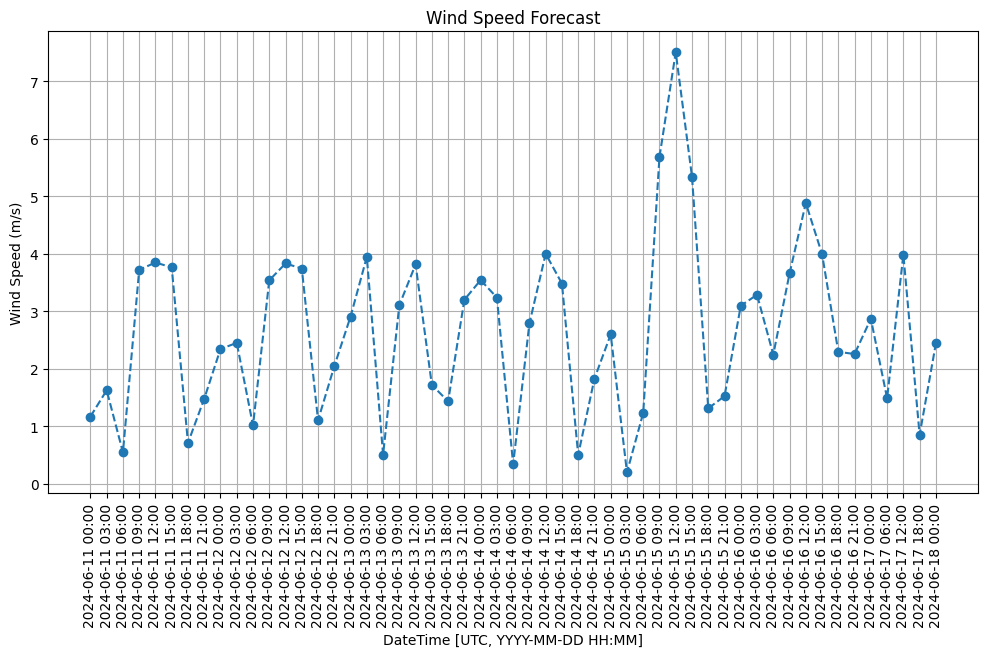

In [9]:
# plot wind speeds with forecast date times
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(pred.time.values).strftime("%Y-%m-%d %H:%M"), pred_wind_speed.values, "--o")
plt.title("Wind Speed Forecast")
plt.xlabel("DateTime [UTC, YYYY-MM-DD HH:MM]")
plt.ylabel("Wind Speed (m/s)")
plt.xticks(rotation=90)
plt.grid()
plt.show()


### SNIPE

In [10]:
# if interested in specific date and time
# model.clear_cache()
preds_dict = model.snipe(target_date = "20240612", 
                         target_time= "1200", 
                         max_hours_back=24*7)

2024-06-26 15:06:34.668 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-12 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240612120000-0h-oper-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.60s/it]

20240612120000-0h-oper-fc.grib2:   0%|          | 0.00/844k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:02,  1.27s/it]

20240612120000-0h-oper-fc.grib2:   0%|          | 0.00/642k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:03,  1.15s/it]
2024-06-26 15:06:38.786 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-12 06:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240612060000-6h-scda-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.08it/s]

20240612060000-6h-scda-fc.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.16it/s]

20240612060000-6h-scda-fc.grib2:   0%|          | 0.00/644k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.18it/s]
2024-06-26 15:06:41.866 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-12 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240612000000-12h-oper-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.15s/it]

20240612000000-12h-oper-fc.grib2:   0%|          | 0.00/844k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.05it/s]

20240612000000-12h-oper-fc.grib2:   0%|          | 0.00/644k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.02it/s]
2024-06-26 15:06:45.583 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-11 18:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240611180000-18h-scda-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.19it/s]

20240611180000-18h-scda-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:02,  1.27s/it]

20240611180000-18h-scda-fc.grib2:   0%|          | 0.00/645k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:03,  1.17s/it]
2024-06-26 15:06:49.712 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-11 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240611120000-24h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.22it/s]

20240611120000-24h-oper-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.07it/s]

20240611120000-24h-oper-fc.grib2:   0%|          | 0.00/645k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.11it/s]
2024-06-26 15:06:53.154 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-11 06:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240611060000-30h-scda-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.12it/s]

20240611060000-30h-scda-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.12it/s]

20240611060000-30h-scda-fc.grib2:   0%|          | 0.00/645k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.12it/s]
2024-06-26 15:06:56.528 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-11 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240611000000-36h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.26s/it]

20240611000000-36h-oper-fc.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:02,  1.01s/it]

20240611000000-36h-oper-fc.grib2:   0%|          | 0.00/645k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.08it/s]
2024-06-26 15:07:00.038 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-10 18:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240610180000-42h-scda-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.09it/s]

20240610180000-42h-scda-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.19it/s]

20240610180000-42h-scda-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.26it/s]
2024-06-26 15:07:02.976 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-10 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240610120000-48h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.15it/s]

20240610120000-48h-oper-fc.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:02,  1.46s/it]

20240610120000-48h-oper-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:03,  1.23s/it]
2024-06-26 15:07:07.375 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-10 06:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240610060000-54h-scda-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.24s/it]

20240610060000-54h-scda-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:02,  1.05s/it]

20240610060000-54h-scda-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:03,  1.01s/it]
2024-06-26 15:07:11.114 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-10 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240610000000-60h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.02it/s]

20240610000000-60h-oper-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.12it/s]

20240610000000-60h-oper-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.14it/s]
2024-06-26 15:07:14.311 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-09 18:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240609180000-66h-scda-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.09it/s]

20240609180000-66h-scda-fc.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.07it/s]

20240609180000-66h-scda-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.16it/s]
2024-06-26 15:07:17.604 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-09 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240609120000-72h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.02it/s]

20240609120000-72h-oper-fc.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.07it/s]

20240609120000-72h-oper-fc.grib2:   0%|          | 0.00/647k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.13it/s]
2024-06-26 15:07:20.812 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-09 06:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240609060000-78h-scda-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.08it/s]

20240609060000-78h-scda-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.13it/s]

20240609060000-78h-scda-fc.grib2:   0%|          | 0.00/647k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.20it/s]
2024-06-26 15:07:23.898 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-09 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240609000000-84h-oper-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.01s/it]

20240609000000-84h-oper-fc.grib2:   0%|          | 0.00/845k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.14it/s]

20240609000000-84h-oper-fc.grib2:   0%|          | 0.00/647k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.15it/s]
2024-06-26 15:07:27.116 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-08 18:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240608180000-90h-scda-fc.grib2:   0%|          | 0.00/851k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.16it/s]

20240608180000-90h-scda-fc.grib2:   0%|          | 0.00/846k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.25it/s]

20240608180000-90h-scda-fc.grib2:   0%|          | 0.00/647k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.23it/s]
2024-06-26 15:07:30.129 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-08 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240608120000-96h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.02s/it]

20240608120000-96h-oper-fc.grib2:   0%|          | 0.00/847k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.10it/s]

20240608120000-96h-oper-fc.grib2:   0%|          | 0.00/648k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.01it/s]
2024-06-26 15:07:33.654 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-08 06:00:00
2024-06-26 15:07:33.999 | WARNING  | skyrim.libs.nwp.ifs:snipe:295 - Invalid or unavailable forecast for start time: 2024-06-08 06:00:00, lead time: 102
2024-06-26 15:07:33.999 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-08 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240608000000-108h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.13it/s]

20240608000000-108h-oper-fc.grib2:   0%|          | 0.00/848k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.13it/s]

20240608000000-108h-oper-fc.grib2:   0%|          | 0.00/648k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.11it/s]
2024-06-26 15:07:37.425 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-07 18:00:00
2024-06-26 15:07:37.777 | WARNING  | skyrim.libs.nwp.ifs:snipe:295 - Invalid or unavailable forecast for start time: 2024-06-07 18:00:00, lead time: 114
2024-06-26 15:07:37.778 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-07 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240607120000-120h-oper-fc.grib2:   0%|          | 0.00/854k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.39s/it]

20240607120000-120h-oper-fc.grib2:   0%|          | 0.00/849k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:02,  1.10s/it]

20240607120000-120h-oper-fc.grib2:   0%|          | 0.00/650k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:03,  1.16s/it]
2024-06-26 15:07:41.981 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-07 06:00:00
2024-06-26 15:07:42.388 | WARNING  | skyrim.libs.nwp.ifs:snipe:295 - Invalid or unavailable forecast for start time: 2024-06-07 06:00:00, lead time: 126
2024-06-26 15:07:42.389 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-07 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240607000000-132h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.06s/it]

20240607000000-132h-oper-fc.grib2:   0%|          | 0.00/849k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.04it/s]

20240607000000-132h-oper-fc.grib2:   0%|          | 0.00/649k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.10it/s]
2024-06-26 15:07:45.807 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-06 18:00:00
2024-06-26 15:07:46.074 | WARNING  | skyrim.libs.nwp.ifs:snipe:295 - Invalid or unavailable forecast for start time: 2024-06-06 18:00:00, lead time: 138
2024-06-26 15:07:46.074 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-06 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240606120000-144h-oper-fc.grib2:   0%|          | 0.00/852k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.08it/s]

20240606120000-144h-oper-fc.grib2:   0%|          | 0.00/844k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.05it/s]

20240606120000-144h-oper-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.11it/s]
2024-06-26 15:07:49.312 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-06 06:00:00
2024-06-26 15:07:49.596 | WARNING  | skyrim.libs.nwp.ifs:snipe:295 - Invalid or unavailable forecast for start time: 2024-06-06 06:00:00, lead time: 150
2024-06-26 15:07:49.597 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-06 00:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240606000000-156h-oper-fc.grib2:   0%|          | 0.00/849k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:00,  1.12it/s]

20240606000000-156h-oper-fc.grib2:   0%|          | 0.00/847k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.25it/s]

20240606000000-156h-oper-fc.grib2:   0%|          | 0.00/646k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.28it/s]
2024-06-26 15:07:52.481 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-05 18:00:00
2024-06-26 15:07:52.869 | WARNING  | skyrim.libs.nwp.ifs:snipe:295 - Invalid or unavailable forecast for start time: 2024-06-05 18:00:00, lead time: 162
2024-06-26 15:07:52.869 | INFO     | skyrim.libs.nwp.ifs:snipe:288 - Fetching for start_time: 2024-06-05 12:00:00
Fetching IFS for {start_time}: 0it [00:00, ?it/s]

20240605120000-168h-oper-fc.grib2:   0%|          | 0.00/849k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 1it [00:01,  1.09s/it]

20240605120000-168h-oper-fc.grib2:   0%|          | 0.00/847k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 2it [00:01,  1.02it/s]

20240605120000-168h-oper-fc.grib2:   0%|          | 0.00/645k [00:00<?, ?B/s]

Fetching IFS for {start_time}: 3it [00:02,  1.09it/s]


In [11]:
print(f"target_date: 20240612, target_time= 1200")
for time, pred in preds_dict.items():
    pred_akyaka = pred.sel(lat=akyaka_coords["lat"], lon=akyaka_coords["lon"], method="nearest")
    pred_wind_speed = (pred_akyaka.sel(channel="u10m")**2 + pred_akyaka.sel(channel="v10m")**2)**0.5
    print(f"Forecast Start DateTime: {pd.to_datetime(time)}, Estimated Wind Speed: {pred_wind_speed.values}")


target_date: 20240612, target_time= 1200
Forecast Start DateTime: 2024-06-12 12:00:00, Estimated Wind Speed: [3.71085696]
Forecast Start DateTime: 2024-06-12 06:00:00, Estimated Wind Speed: [3.92185866]
Forecast Start DateTime: 2024-06-12 00:00:00, Estimated Wind Speed: [4.0672767]
Forecast Start DateTime: 2024-06-11 18:00:00, Estimated Wind Speed: [3.85858281]
Forecast Start DateTime: 2024-06-11 12:00:00, Estimated Wind Speed: [3.80209119]
Forecast Start DateTime: 2024-06-11 06:00:00, Estimated Wind Speed: [3.77831785]
Forecast Start DateTime: 2024-06-11 00:00:00, Estimated Wind Speed: [3.83439972]
Forecast Start DateTime: 2024-06-10 18:00:00, Estimated Wind Speed: [3.82775865]
Forecast Start DateTime: 2024-06-10 12:00:00, Estimated Wind Speed: [4.2925233]
Forecast Start DateTime: 2024-06-10 06:00:00, Estimated Wind Speed: [4.23230368]
Forecast Start DateTime: 2024-06-10 00:00:00, Estimated Wind Speed: [4.13971324]
Forecast Start DateTime: 2024-06-09 18:00:00, Estimated Wind Speed: [4